In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import GRU, Dense, Embedding, Dropout
from keras.metrics import Precision, Recall
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from gensim.models import Word2Vec
from gensim.models import FastText
from gensim.models import KeyedVectors
import tensorflow_hub as hub
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import ConfusionMatrixDisplay
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import Input, Lambda, Dense, GRU, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
# Load the dataset
data = pd.read_csv('urdu-sentiment-corpus-v1.tsv', sep='\t', header=None)

In [3]:
data = data.rename(columns={0: 'tweets', 1: 'class'})
data = data.drop(0)

In [4]:
data.head()

,tweets,class
1,میں نے ایٹم بم بنایا ھے ۔۔۔۔او بھائی ایٹم بمب ...,P
2,چندے سے انقلاب اور عمران خان وزیر اعظم نہیں بن...,N
3,ٹویٹر کا خیال کیسے آیا ؟,O
4,"سرچ انجن گوگل کے نائب صدر نے فضا میں ، 130,000...",P
5,ابھی تک اسکی لہریں کبھی کبھی آ جاتی ہیں یار :أْ,P


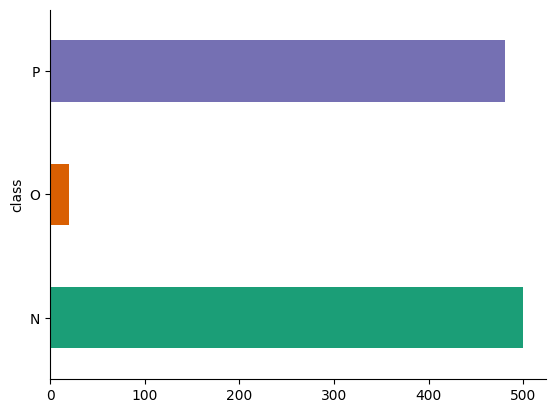

In [5]:
# @title class

from matplotlib import pyplot as plt
import seaborn as sns
data.groupby('class').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [6]:
data = data.dropna()

In [7]:
data = data[1:]
data.columns = ['Tweet', 'Class']
data = data[data['Class'].isin(['P', 'N'])]

data['Class'] = data['Class'].apply(lambda x: 1 if x == 'P' else 0)

In [8]:
# Preprocessing (if needed)
# Tokenization, removing punctuation, stopwords, etc.

# Tokenization - Split text into words
tokenized_text = data['Tweet'].apply(lambda x: x.split())

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=1, workers=4)

# Prepare data for GRU model
max_len = max(len(tokens) for tokens in tokenized_text)
X = [[word2vec_model.wv[word] for word in tokens] for tokens in tokenized_text]
X_pad = pad_sequences(X, maxlen=max_len, padding='post', dtype='float32')

y = to_categorical(data['Class'])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.25, random_state=42)

# Define and train the GRU model
model = Sequential()
model.add(GRU(128, return_sequences=True, input_shape=(max_len, 100)))
model.add(Dropout(0.3))
model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(128))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 36, 128)           88320     
                                                                 
 dropout (Dropout)           (None, 36, 128)           0         
                                                                 
 gru_1 (GRU)                 (None, 36, 128)           99072     
                                                                 
 dropout_1 (Dropout)         (None, 36, 128)           0         
                                                                 
 gru_2 (GRU)                 (None, 128)               99072     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 2)                 2

In [12]:
history = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test), shuffle=True)

Epoch 1/50
6/6 [==============================] - 0s 31ms/step - loss: 0.6683 - accuracy: 0.5512 - val_loss: 0.7046 - val_accuracy: 0.5020
Epoch 2/50
6/6 [==============================] - 0s 22ms/step - loss: 0.6725 - accuracy: 0.5457 - val_loss: 0.7089 - val_accuracy: 0.4449
Epoch 3/50
6/6 [==============================] - 0s 23ms/step - loss: 0.6647 - accuracy: 0.5484 - val_loss: 0.7211 - val_accuracy: 0.4694
Epoch 4/50
6/6 [==============================] - 0s 20ms/step - loss: 0.6564 - accuracy: 0.5730 - val_loss: 0.7151 - val_accuracy: 0.4694
Epoch 5/50
6/6 [==============================] - 0s 19ms/step - loss: 0.6524 - accuracy: 0.5880 - val_loss: 0.7355 - val_accuracy: 0.4694
Epoch 6/50
6/6 [==============================] - 0s 19ms/step - loss: 0.6565 - accuracy: 0.5580 - val_loss: 0.7060 - val_accuracy: 0.4898
Epoch 7/50
6/6 [==============================] - 0s 20ms/step - loss: 0.6559 - accuracy: 0.5962 - val_loss: 0.7285 - val_accuracy: 0.4490
Epoch 8/50
6/6 [===========

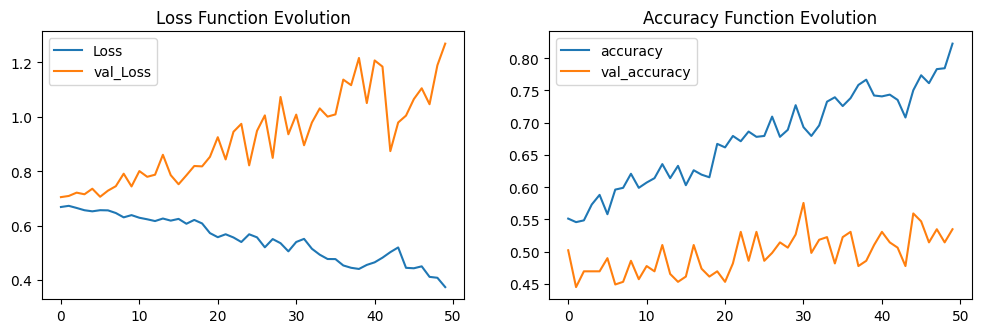

In [13]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()

In [14]:
print(f"Training Accuracy: {history.history['accuracy'][-1]}")

Training Accuracy: 0.8226466774940491


In [15]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred = np.round(y_pred).argmax(axis=1)
    y_true = y_test.argmax(axis=1)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    f_score = f1_score(y_true, y_pred, average='binary')

    return accuracy, precision, recall, f_score

In [16]:
evaluate_model(model, X_test, y_test)

8/8 [==============================] - 1s 6ms/step


(0.5346938775510204, 0.5643564356435643, 0.44881889763779526, 0.5)

# **ELMO**

In [24]:
data.head()

,Tweet,Class
2,چندے سے انقلاب اور عمران خان وزیر اعظم نہیں بن...,0
4,"سرچ انجن گوگل کے نائب صدر نے فضا میں ، 130,000...",1
5,ابھی تک اسکی لہریں کبھی کبھی آ جاتی ہیں یار :أْ,1
6,گندی زبان اور گٹر جیسے دماغ والے جاهل جیالے ه...,0
7,"قاتل بھی تم مقتول بھی تم,ظالم بھی ہم اور مظلوم...",0


In [26]:
data.shape

(978, 2)

In [32]:
import pandas as pd
import numpy as np
import spacy
from tqdm import tqdm
import re
import time
import pickle
pd.set_option('display.max_colwidth', 200)

from sklearn import preprocessing
import keras

In [39]:
!pip install tensorflow==1.15
!pip install "tensorflow_hub>=0.6.0"
!pip3 install tensorflow_text==1.15

ERROR: Could not find a version that satisfies the requirement tensorflow==1.15 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1)
ERROR: No matching distribution found for tensorflow==1.15
ERROR: Could not find a version that satisfies the requirement tensorflow_text==1.15 (from versions: 2.8.1, 2.8.2, 2.9.0rc0, 2.9.0rc1, 2.9.0, 2.10.0b2, 2.10.0rc0, 2.10.0, 2.11.0rc0, 2.11.0, 2.12.0rc0, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0, 2.14.0rc0, 2.14.0, 2.15.0rc0, 2.15.0, 2.16.0rc0, 2.16.1)
ERROR: No matching distribution found for tensorflow_text==1.15


In [41]:
import tensorflow_hub as hub
import tensorflow as tf

embed = hub.load("https://tfhub.dev/google/elmo/2")

In [33]:
y = list(data['Class'])
x = list(data['Tweet'])

le = preprocessing.LabelEncoder()
le.fit(y)

def encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def decode(le, one_hot):
    dec = np.argmax(one_hot, axis=1)
    return le.inverse_transform(dec)


x_enc = x
y_enc = encode(le, y)

In [34]:
x_train, x_test, y_train, y_test = train_test_split(np.asarray(x_enc), np.asarray(y_enc), test_size=0.2, random_state=42)

In [35]:
x_train.shape
y_train.shape

(782, 2)

In [42]:
from keras.layers import Input, Lambda, Dense
from keras.models import Model
import keras.backend as K

def ELMoEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

input_text = Input(shape=(1,), dtype=tf.string)
embedding = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_text)
dense = Dense(256, activation='relu')(embedding)
pred = Dense(143, activation='softmax')(dense)
model = Model(inputs=[input_text], outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    history = model.fit(x_train, y_train, epochs=1, batch_size=16)
    model.save_weights('./elmo-model.h5')

with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    model.load_weights('./elmo-model.h5')
    predicts = model.predict(x_test, batch_size=16)

y_test = decode(le, y_test)
y_preds = decode(le, predicts)


TypeError: Exception encountered when calling layer "lambda_1" (type Lambda).

'AutoTrackable' object is not callable

Call arguments received by layer "lambda_1" (type Lambda):
  • inputs=tf.Tensor(shape=(None, 1), dtype=string)
  • mask=None
  • training=None

# **FASTTEXT**